In [190]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from helper_funcs import *

In [274]:
zipdata = get_zipdata()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 43)

In [192]:
zipdata = zipdata.loc[zipdata.Population!=0]

In [194]:
zipdata.shape

(5036, 43)

#### Fill the following columns with 0 for NaN values

In [275]:
zipdata.loc[zipdata.over_65_ratio.isna(),'over_65_ratio'] = 0
zipdata.loc[zipdata.Hosp_count.isna(),'Hosp_count'] = 0
zipdata.loc[zipdata.HPI.isna(),'HPI'] = 0
zipdata.loc[zipdata.Demand_score.isna(),'Demand_score'] = 0
zipdata.loc[zipdata.Supply_score.isna(),'Supply_score'] = 0
zipdata.loc[zipdata.listviews_vs_US.isna(),'listviews_vs_US'] = 0
zipdata.loc[zipdata.med_days_on_mkt.isna(),'med_days_on_mkt'] = 0
zipdata.loc[zipdata.nielson_rank.isna(),'nielson_rank'] = 0
zipdata.loc[zipdata.Zillow_HVF.isna(),'Zillow_HVF'] = 0

#### Fill the following columns with the Mean for NaN values

In [276]:
zipdata.loc[zipdata.school_rating.isna(),'school_rating'] = 5
zipdata.loc[zipdata.UE_rate.isna(),'UE_rate'] = zipdata.UE_rate.mean()
zipdata.loc[zipdata.BEA_percap_income.isna(),'BEA_percap_income'] = zipdata.BEA_percap_income.mean()

#### Remove unused location data, and building permits data for now

In [277]:
zipdata.drop(columns=zipdata.columns[-13:], inplace=True)
zipdata.drop(columns=zipdata.columns[:5], inplace=True)

In [278]:
zipdata.isna().sum()

Population              0
HouseholdsPerZipCode    0
WhitePopulation         0
BlackPopulation         0
HispanicPopulation      0
AsianPopulation         0
IndianPopulation        0
OtherPopulation         0
MalePopulation          0
FemalePopulation        0
AverageHouseValue       0
IncomePerHousehold      0
MedianAge               0
NumberOfBusinesses      0
over_65_ratio           0
school_rating           0
Hosp_count              0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
UE_rate                 0
Zillow_HVF              0
dtype: int64

Check Some correlations

<AxesSubplot:>

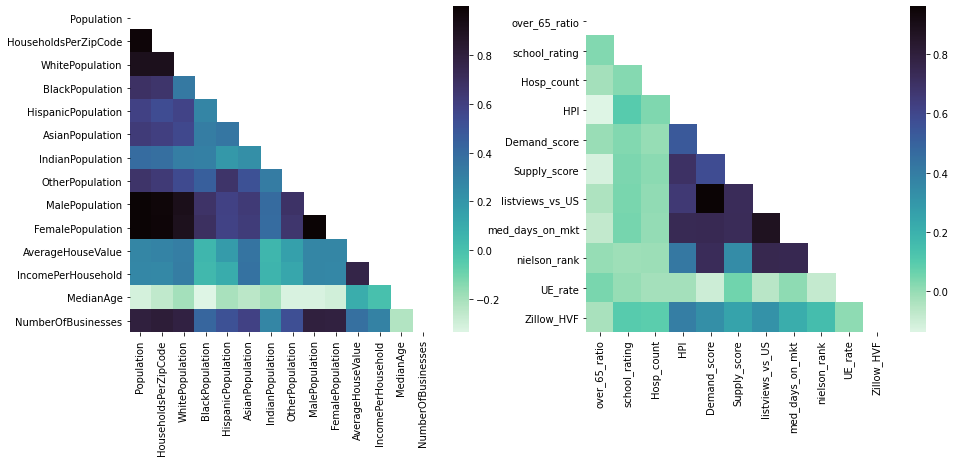

In [200]:
corr1 = zipdata.iloc[:,0:14].corr()
corr2 = zipdata.iloc[:,14:].corr()

mask1 = np.triu(np.ones_like(corr1, dtype=bool)) # Hide upper redundant heatmap
mask2 = np.triu(np.ones_like(corr2, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(corr1, mask=mask1, ax=ax[0], annot=False, cmap='mako_r')
sns.heatmap(corr2, mask=mask2, ax=ax[1], annot=False, cmap='mako_r')

Create Population Ratios

In [279]:
zipdata['Blacks_ratio'] = zipdata.BlackPopulation / zipdata.Population
zipdata['Hispanics_ratio'] = zipdata.HispanicPopulation / zipdata.Population
zipdata['Asians_ratio'] = zipdata.AsianPopulation / zipdata.Population
zipdata['Indians_ratio'] = zipdata.IndianPopulation / zipdata.Population
zipdata['Others_ratio'] = zipdata.OtherPopulation / zipdata.Population
zipdata['Male_ratio'] = zipdata.MalePopulation / zipdata.Population
zipdata.loc[zipdata.Blacks_ratio.isna(),'Blacks_ratio'] = 0
zipdata.loc[zipdata.Hispanics_ratio.isna(),'Hispanics_ratio'] = 0
zipdata.loc[zipdata.Asians_ratio.isna(),'Asians_ratio'] = 0
zipdata.loc[zipdata.Indians_ratio.isna(),'Indians_ratio'] = 0
zipdata.loc[zipdata.Others_ratio.isna(),'Others_ratio'] = 0
zipdata.loc[zipdata.Male_ratio.isna(),'Male_ratio'] = 0

zipdata.drop(columns=['BlackPopulation','HispanicPopulation','AsianPopulation',
                      'IndianPopulation','OtherPopulation','MalePopulation','FemalePopulation'], inplace=True)

<AxesSubplot:>

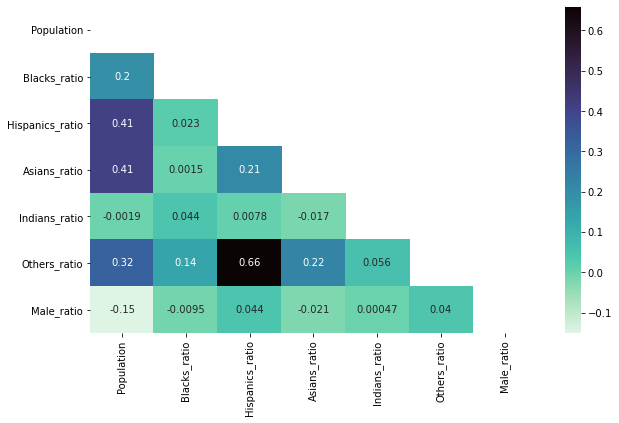

In [202]:
corrmatrix = zipdata[['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio',
       'Others_ratio', 'Male_ratio']].corr()
mask = np.triu(np.ones_like(corrmatrix, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrmatrix, mask=mask, annot=True, cmap='mako_r')

### 🎚️ Scale data before clustering

In [285]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(zipdata.drop(columns='AverageHouseValue').values), 
                           columns=zipdata.drop(columns='AverageHouseValue').columns, 
                           index=zipdata.drop(columns='AverageHouseValue').index)

### K-means Clustering of ZipCode data to produce desirability Clusters

In [286]:
kmeans = KMeans()
inertias = {}
for n in range(1,30):
    kmeans.set_params(n_clusters=n)
    kmeans.fit(data_scaled)
    inertias[n] = kmeans.inertia_

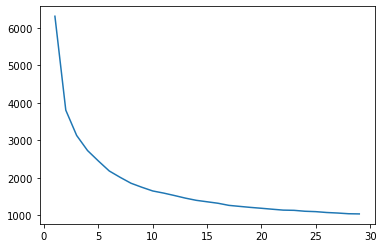

In [287]:
plt.plot(inertias.keys(),inertias.values())

#### Try 10 Clusters

In [288]:
kmeans.set_params(n_clusters=10)
kmeans.fit(data_scaled)
zipdata['cluster'] = kmeans.labels_

In [289]:
zipdata.columns

Index(['Population', 'HouseholdsPerZipCode', 'WhitePopulation',
       'AverageHouseValue', 'IncomePerHousehold', 'MedianAge',
       'NumberOfBusinesses', 'over_65_ratio', 'school_rating', 'Hosp_count',
       'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US',
       'med_days_on_mkt', 'nielson_rank', 'UE_rate', 'Zillow_HVF',
       'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio',
       'Others_ratio', 'Male_ratio', 'cluster'],
      dtype='object')

In [239]:
print(zipdata.groupby('cluster').agg('count')['Population'])
zipdata.groupby('cluster').agg('mean')[['AverageHouseValue','Population','over_65_ratio',
                                       'IncomePerHousehold','school_rating','Hosp_count',
                                       'HPI','UE_rate','Zillow_HVF','NumberOfBusinesses']].round(2).sort_values(by='AverageHouseValue')

cluster
0     513
1     555
2     473
3     216
4     393
5     362
6    1304
7     264
8     530
9     426
Name: Population, dtype: int64


,AverageHouseValue,Population,over_65_ratio,IncomePerHousehold,school_rating,Hosp_count,HPI,UE_rate,Zillow_HVF,NumberOfBusinesses
cluster,,,,,,,,,,
0,95744.64,4625.99,0.21,37361.55,4.39,0.04,1.31,4.23,3.40,78.67
6,124819.71,2701.05,0.23,42171.09,5.19,0.03,0.00,4.26,4.88,49.97
5,137639.23,5788.99,0.19,48287.34,5.30,0.03,259.70,4.10,12.40,118.41
8,139197.92,6325.88,0.20,48156.87,5.19,0.05,249.62,3.98,9.82,145.67
1,173705.23,8083.28,0.21,53279.87,5.20,0.01,271.25,4.27,15.87,190.17
4,206402.54,32980.57,0.17,59651.70,5.19,0.20,297.88,4.20,17.53,910.93
9,236900.47,26791.95,0.19,58546.19,5.45,0.18,0.00,4.23,17.79,828.68
3,240190.74,34708.37,0.14,68656.75,5.50,0.19,280.28,4.14,19.64,984.97
2,302733.40,4847.41,0.18,82256.15,5.55,0.01,305.07,4.44,8.70,129.94


## 🎰 Model with Clusters

In [257]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

In [298]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(75360, 20)


In [299]:
RF.drop(RF[RF.BEDS.isna() | RF.BATHS.isna()].index, inplace=True)
#RF.loc[RF.overallRating.isna(),'overallRating'] = 5

#### Merge cluster into House data

In [300]:
print(f'shape before merge: {RF.shape}')
RF = RF.merge(zipdata, how = 'left', left_on = 'zip', right_index=True)
RF.cluster = RF.cluster.astype('object')
print(f'shape after merge: {RF.shape}')

shape before merge: (75201, 20)
shape after merge: (75201, 45)


<AxesSubplot:xlabel='cluster', ylabel='PRICE'>

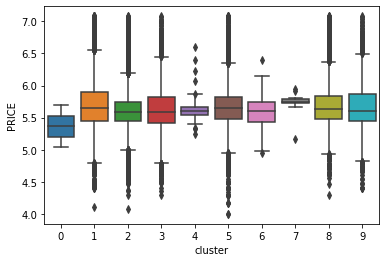

In [302]:
sns.boxplot(x=RF.cluster, y=np.log10(RF.PRICE))

In [292]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54839, 8)
X_test rows: (19199, 8)


In [293]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)

In [294]:
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.753986051860511
train R2: 0.727882801550633


## 🐱 Try CatBoost
* Label Encode **Prop_Type & zip**

In [295]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [296]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8221543722226234
Test R2: 0.795604840626706


## Miniscule improvements with Cluster information

🦏 Try **Full** Model by directly adding ZipCode Level information & feature select with Lasso

In [342]:
# Use all columns except 
# PRICE, Sale_Type, Sold_Date, ADDRESS, CITY, State, px_perSF, HOA_perMonth, 
# Status, LATITUDE, LONGITUDE, LOCATION, Days_on_Mkt, AverageHouseValue
unwanted = ['PRICE','Sale_Type', 'Sold_Date', 'ADDRESS', 'CITY', 'State', 'LOCATION',
            'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE', 'LONGITUDE','AverageHouseValue']
RF.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Population', 'HouseholdsPerZipCode',
       'WhitePopulation', 'AverageHouseValue', 'IncomePerHousehold',
       'MedianAge', 'NumberOfBusinesses', 'over_65_ratio', 'school_rating',
       'Hosp_count', 'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US',
       'med_days_on_mkt', 'nielson_rank', 'UE_rate', 'Zillow_HVF',
       'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio',
       'Others_ratio', 'Male_ratio', 'cluster', 'houses_perZIP'],
      dtype='object')

In [343]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d.drop(columns=unwanted)
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d.drop(columns=unwanted)
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54839, 32)
X_test rows: (19199, 32)


In [344]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)
lasso = Lasso()
lasso.set_params(normalize=True, max_iter=10000, random_state=44)
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 44,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [345]:
#try different alphas
alphas = np.linspace(0.000001,0.00001,10)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_dum, y_train)
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train_dum, y_train))
    R2_test.append(lasso.score(X_test_dum, y_test))

In [346]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train_dum.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,BEDS,BATHS,SF,Lot_Size,YearBuilt,Population,HouseholdsPerZipCode,WhitePopulation,IncomePerHousehold,MedianAge,...,zip_34994,zip_34996,zip_34997,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_8,cluster_9
0.000001,0.008154,0.005586,0.000144,1.883803e-10,0.001431,-0.0,1.164476e-06,-0.000007,0.000002,0.0,...,0.020629,0.119185,-0.028105,-0.033235,-0.016735,0.000000,0.023235,0.000016,-0.036497,-0.0
0.000002,0.007906,0.005788,0.000144,1.643179e-10,0.001347,-0.0,7.588042e-07,-0.000006,0.000002,0.0,...,0.016670,0.111429,-0.019072,-0.035354,-0.018800,0.000026,0.013415,0.000008,-0.036678,-0.0


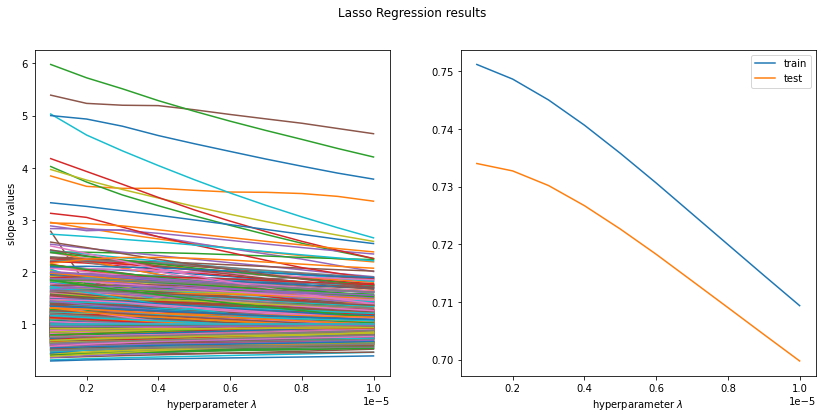

In [347]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

In [348]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [349]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8864714016560817
Test R2: 0.8578662235143302


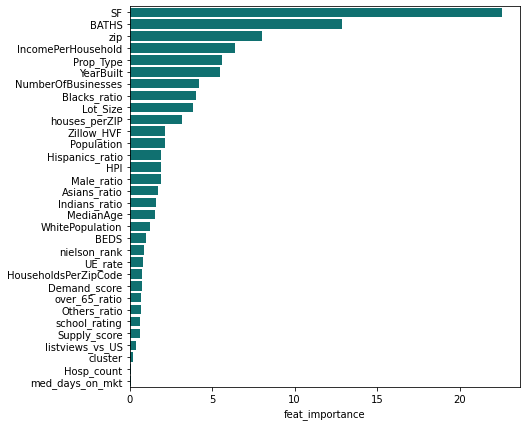

In [350]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");